# Module 3 Final Project

Student name: Isabella Lindgren <br/>
Student pace: Part Time <br/>
Scheduled project review date/time: TBD <br/>
Instructor name: Eli Thomas

## The Scientific Method

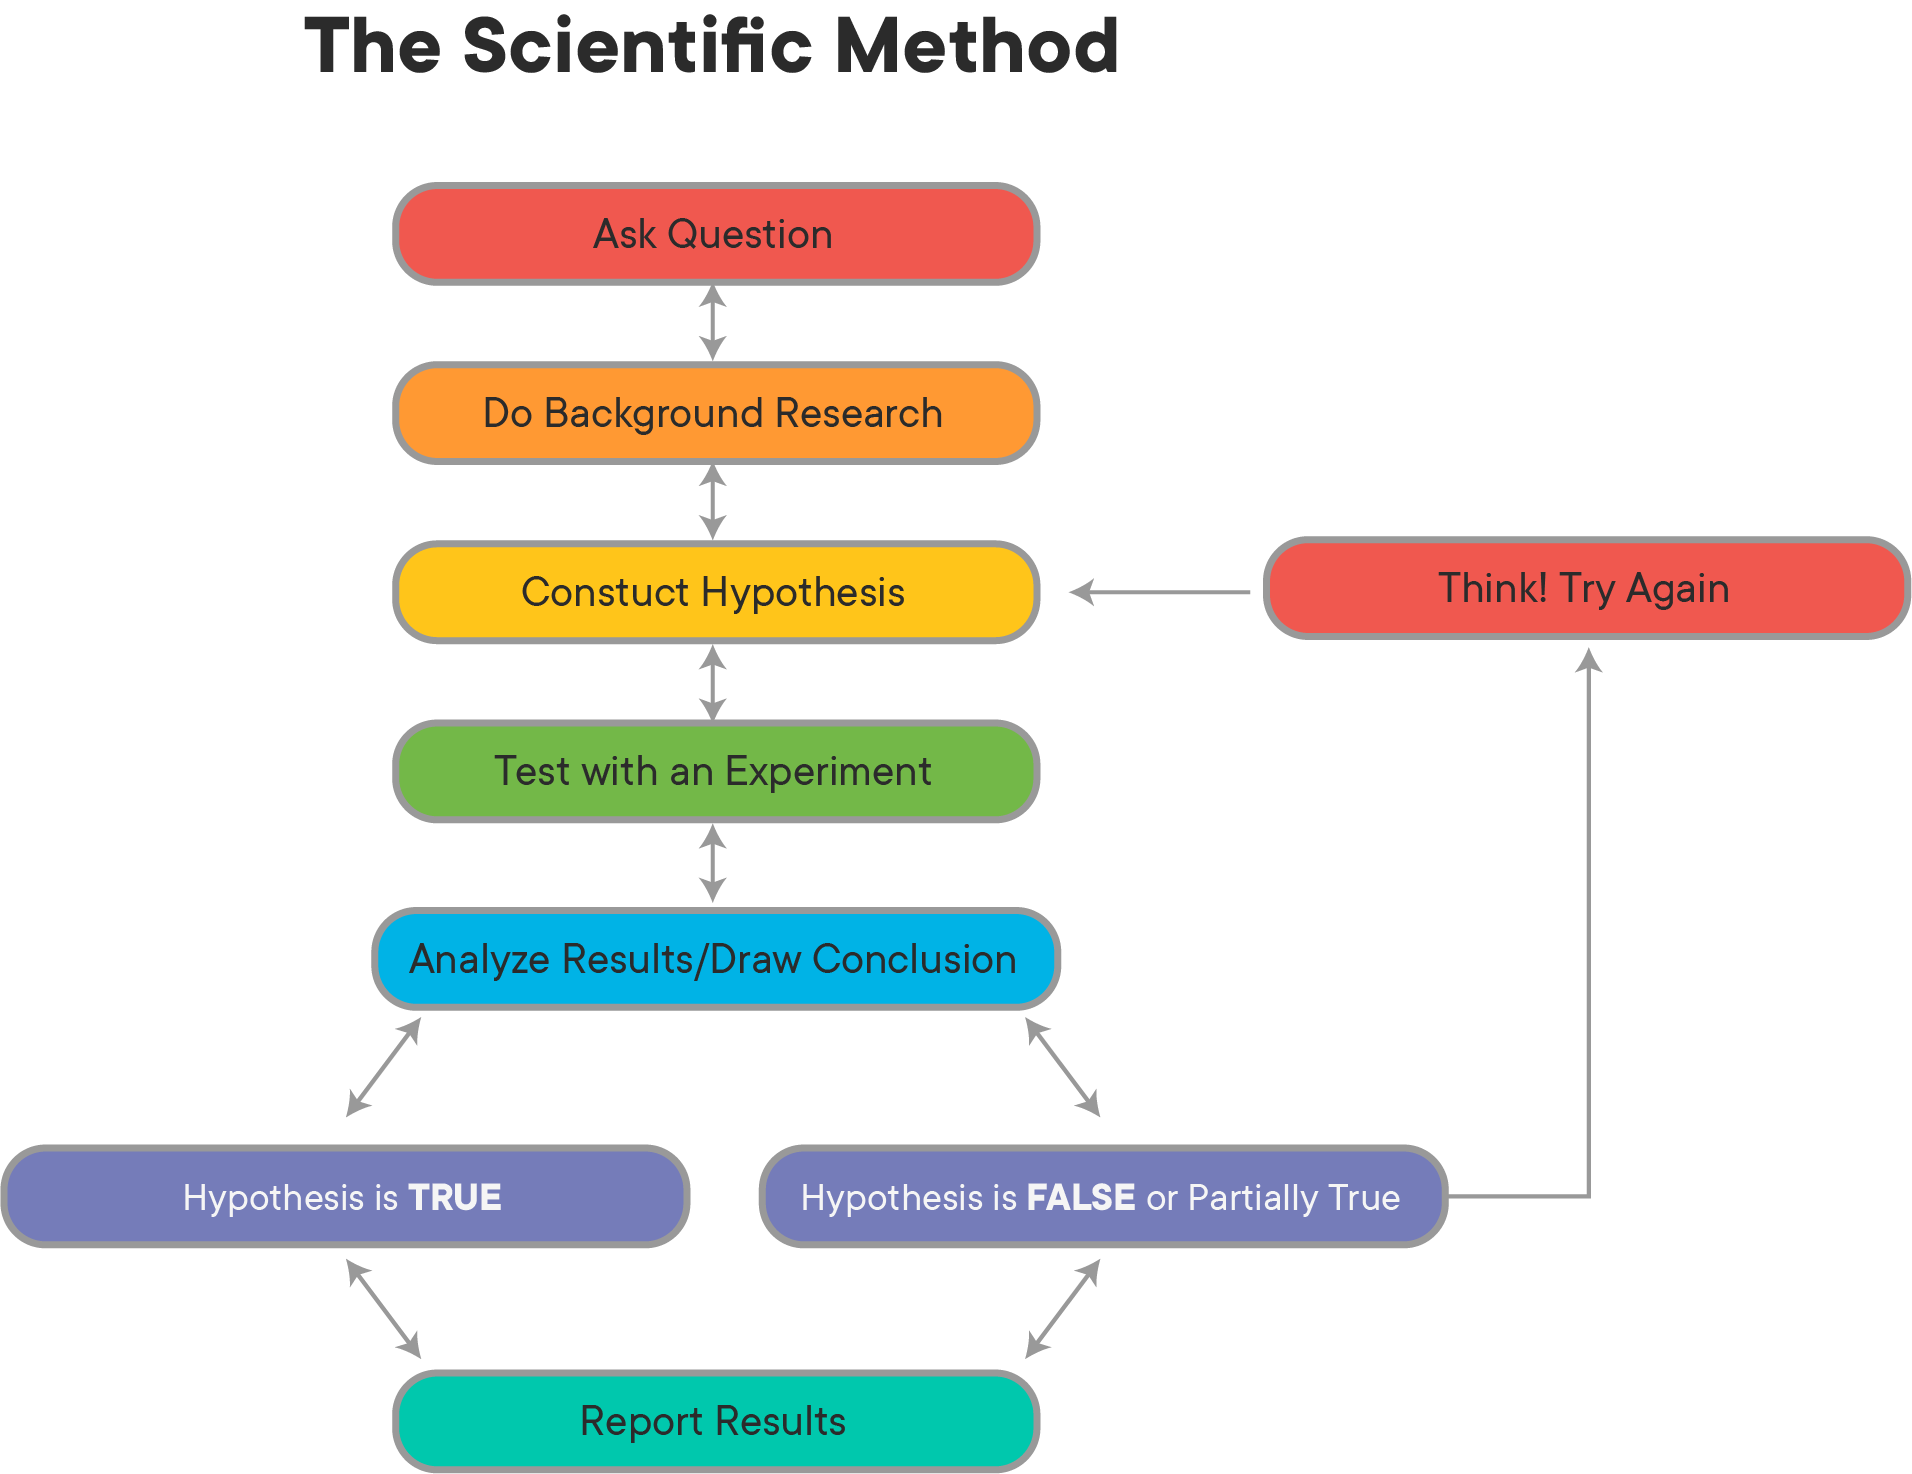

The scientific method is the process for creating and carrying out an experiment to obtain observations and answer questions. In this module, we will be demonstrating each step of the scientific method to answer questions regarding the Northwind Traders Database.

## Northwind Traders Database <br/>

Northwind Traders is a sample database for a fictitious specialty food trading company. It contains all sales transactions that occur between the company Northwind Traders and its customers as well as the purchase transactions between Northwind Traders and its suppliers.

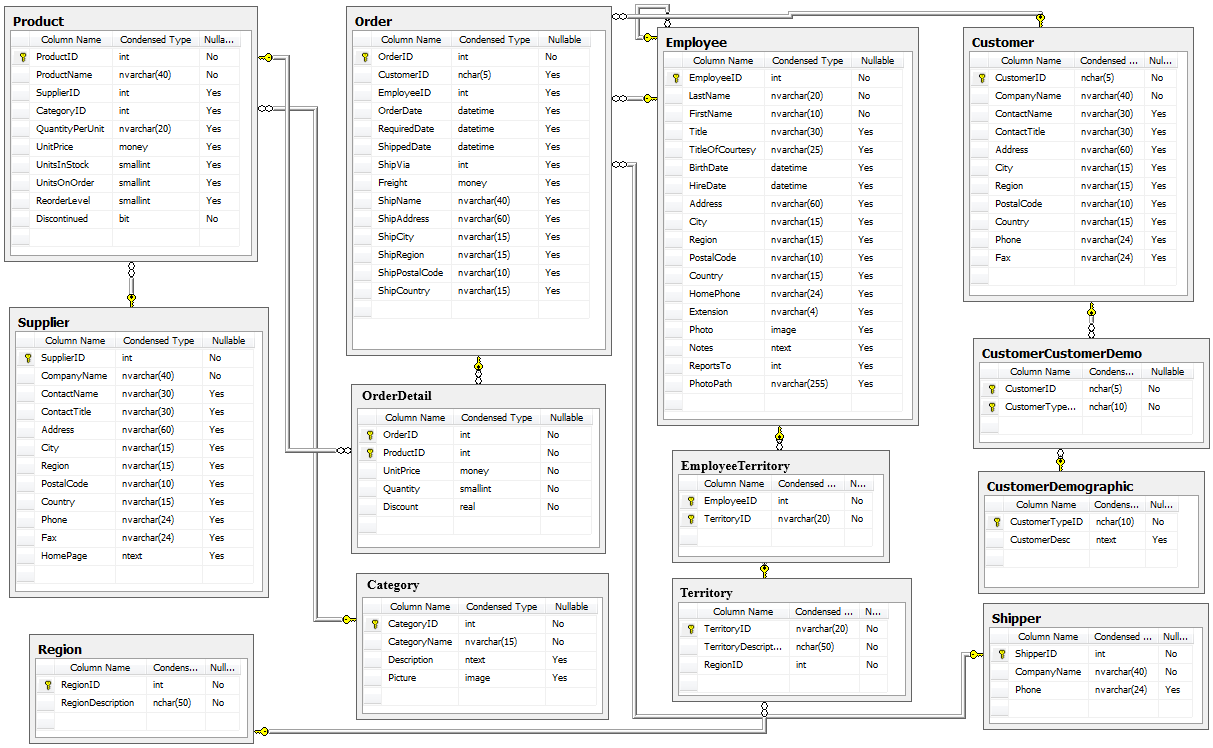

### Background information:
1.	Suppliers/Vendors of Northwind – who supplies the company.
2.	Customers of Northwind – who buys from Northwind
3.	Employee details of Northwind traders – who works for Northwind
4.	The product information – the products that Northwind trades in
5.	The inventory details – the details of the inventory held by Northwind traders.
6.	The shippers – details of the shippers who ship the products from the traders to the end-customers
7.	PO transactions i.e Purchase Order transactions – details of the transactions taking place between vendors & the company.
8.	Sales Order transaction – details of the transactions taking place between the customers & the company.
9.	Inventory transactions – details of the transactions taking place in the inventory
10.	Invoices – details of the invoice raised against the order.

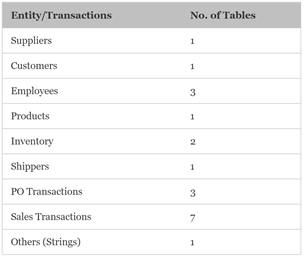
Source: https://theaccessbuddy.wordpress.com/2011/07/03/northwind-database-explained/

It is important to take into account how each of these tables are linked in order to answer complex questions from a variety of perspectives. We will explore these relationships in our Exploratory Data Analysis section

# Objectives:

The purpose of this project is to query data from the Northwind Traders database and use statistical analysis and hypothesis testing to generate analytical insights into the following questions:

>**1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?** <br/><br/>
**2. Is there a statistically significant difference between the revenue US employees bring in compared to UK employees?**<br/><br/>
**3. Do people who order more frequently than average also generate more sales?**<br/><br/>
**4. Is there a significant difference in the freight costs per region?**

First, import all the necessary libraries.

In [347]:
import sqlite3 as sql
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import numpy as np 
import scipy.stats as scs
import itertools 
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

Then, we connect to the Northwind Traders database to grab information.

In [424]:
conn = sql.connect('Northwind_small.sqlite')
c = conn.cursor()
table_names = c.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table';''').fetchall()
table_names = [i[0] for i in table_names]
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

Next, we convert all the tables into dataframes which are easier to manipulate and analyze.

In [249]:
dfs = []
for i in table_names:
    # select all data for each column
    table = c.execute('SELECT * FROM "'+i+'"').fetchall()         
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # change string into a variable name
    x = i+"_df"
    exec(x + " = df")
    # add new df names to list 'dfs'
    dfs.append(x)

In [250]:
dfs

['Employee_df',
 'Category_df',
 'Customer_df',
 'Shipper_df',
 'Supplier_df',
 'Order_df',
 'Product_df',
 'OrderDetail_df',
 'CustomerCustomerDemo_df',
 'CustomerDemographic_df',
 'Region_df',
 'Territory_df',
 'EmployeeTerritory_df']

## Exploratory Data Analysis

### Revenue per Day

In [349]:
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [369]:
order_quant_by_date = pd.read_sql_query('''SELECT OrderDate,  
                                           COUNT('Id') as Quantity_Ord,
                                           SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                                           FROM [Order]
                                           INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                                           GROUP BY OrderDate ORDER BY Quantity_Ord DESC
                                           ;''', conn)

order_quant_by_date.head()
print(order_quant_by_date.describe())

       Quantity_Ord       Revenue
count    480.000000    480.000000
mean       4.489583   2815.302016
std        2.764201   3125.673977
min        1.000000     49.800000
25%        3.000000    910.645000
50%        4.000000   2035.125000
75%        6.000000   3400.822500
max       32.000000  31153.572500


The mean revenue per day is $2,815. <br/>
The mean orders per day is approx 4.49.

### Revenue Per Customer

In [379]:
rev_by_custom = pd.read_sql_query('''SELECT CustomerId,  
                                           SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                                           FROM [Order]
                                           INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                                           GROUP BY CustomerId ORDER BY 'Revenue' DESC
                                           ;''', conn)

print(rev_by_custom.head(5))
print(rev_by_custom.describe())

  CustomerId     Revenue
0      ALFKI   4572.7875
1      ANATR   1402.9500
2       ANTO   7490.0880
3      AROUT  13792.9550
4      BERGS  26860.2475
             Revenue
count      89.000000
mean    15183.651320
std     21911.541785
min       100.800000
25%      3361.000000
50%      7519.750000
75%     18080.330000
max    117320.980000


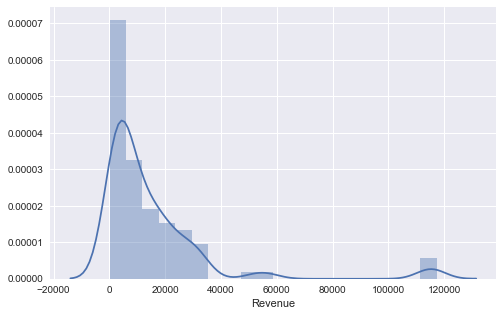

In [376]:
sns_histogram(rev_by_custom.Revenue);

### Quantity of Discounted Products vs Non-Discounted Products

In [264]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [265]:
OrderDetail_df[['Quantity', 'Discount']].describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


In [268]:
# Function for plotting histograms
def sns_histogram(values, bins=20, alpha=0.5):
    plt.figure(figsize=(8, 5))
    plt.grid(True)
    sns.distplot(values, bins=bins)
    plt.show()

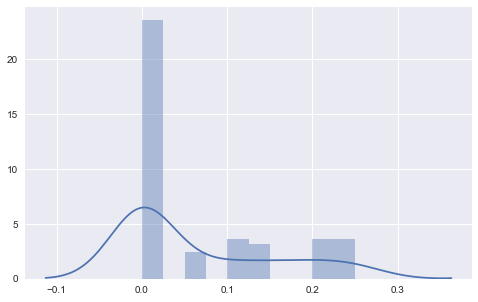

In [269]:
sns_histogram(np.random.choice(OrderDetail_df.Discount, size = 100), bins = 10)

In [281]:
OrderDetail_df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [282]:
#OrderDetail_df['Discount_bin'] = OrderDetail_df['Discount'].apply(lambda x: 1 if x > 0 else 0)

In [283]:
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()

Text(0.5, 1.0, 'Discount v.s. No Discount Average Quantity of Product Per Order')

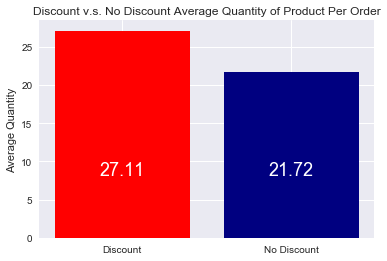

In [295]:
# X = ['Discount', 'No Discount']
# y = [OrderDetail_df['Quantity'][OrderDetail_df['Discount_bin'] == 1].mean(),
#      OrderDetail_df['Quantity'][OrderDetail_df['Discount_bin'] == 0].mean()]

# plt.bar(X,y, color=('red','navy'))
# plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center', verticalalignment='top', size=18)
# plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center', verticalalignment='top', size=18)
# plt.ylabel('Average Quantity')
# plt.title('Discount v.s. No Discount Average Quantity of Product Per Order')

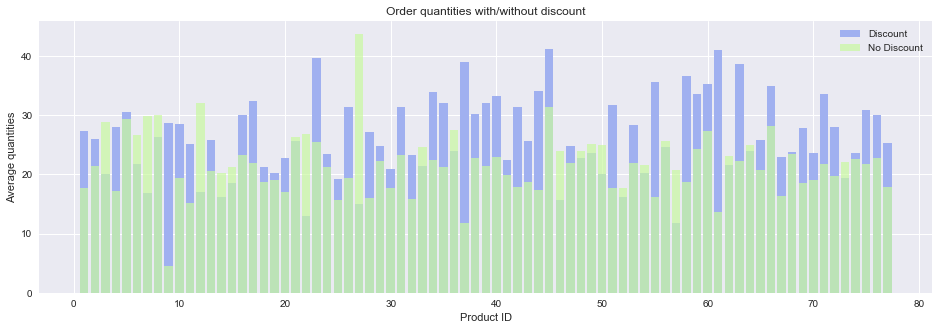

Conclusion
On average 70.0% of discounted products were sold in larger quantities
Average order quantity with discount - 26.43 items, without - 21.81 items


In [189]:
# # Great visualization plot comparing order quantities with discounts and without discounts by Product ID
# # provided by Arseniyturin source: https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb

# discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
# no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
# plt.figure(figsize=(16,5))

# plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='#a0b0f0')
# plt.bar(no_discount.index, no_discount.values, alpha=0.7, label='No Discount', color='#c9f9a0')
# plt.legend()
# plt.title('Order quantities with/without discount')
# plt.xlabel('Product ID')
# plt.ylabel('Average quantities')
# plt.show()

# print('Conclusion')
# print("On average {}% of discounted products were sold in larger quantities".format(round(sum(discount.values > no_discount.values)/len(discount.values)*100),2))
# print("Average order quantity with discount - {} items, without - {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

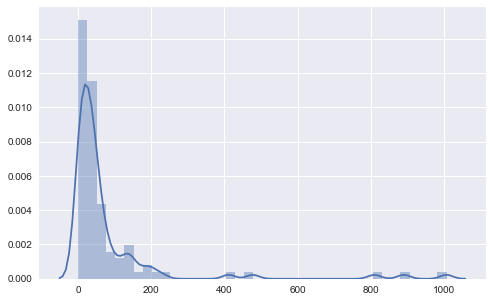

In [270]:
sns_histogram(np.random.choice(Order_df.Freight, size = 100), bins = 40)

# Question 1 
## *Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?*

In order to answer this question, we should break it down into two parts: the null hypothesis (H<sub>0</sub>) and the alternative hypothesis (H<sub>1</sub>). The null hypothesis is when there is no significant difference between specified populations. The alternate hypothesis is the opposite of the null hypothesis and it is the focus of our testing.

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no difference in the quantity of product in orders with a discount compared to orders without a discount.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub>The discount amount has an effect on the quantity of product in an order.

We will be using a two-tailed test to answer this question because if we do reject the null hypothesis, we can determine if the discount amount has a positive or negative effect on the quantity of a product in an order.
<br/>
<br/>
To test our hypotheses, we will need the 'Quantity' and 'Discount' columns in our 'OrderDetail_df' table. 

In [485]:
data1 = OrderDetail_df[['Quantity', 'Discount','UnitPrice']]
data1.info() # see the number of values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
Quantity     2155 non-null int64
Discount     2155 non-null float64
UnitPrice    2155 non-null float64
dtypes: float64(2), int64(1)
memory usage: 50.6 KB


We can see that there are no missing values in either the 'Quantity' or the 'Discount' column.

In [486]:
data1.describe() # basic stats 

,Quantity,Discount,UnitPrice
count,2155.000000,2155.000000,2155.000000
mean,23.812993,0.056167,26.218520
std,19.022047,0.083450,29.827418
min,1.000000,0.000000,2.000000
25%,10.000000,0.000000,12.000000
50%,20.000000,0.000000,18.400000
75%,30.000000,0.100000,32.000000
max,130.000000,0.250000,263.500000


The mean amount of items purchased per order is approximately 24 items, with orders ranging from 1 product to 130 products. The mean discount is 0.056 with a range from 0 to .25.

In [487]:
discounts = data1['Discount'].unique()
discounts

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [488]:
no_discount = OrderDetail_df[OrderDetail_df['Discount'] == 0].copy()
discount = OrderDetail_df[OrderDetail_df['Discount'] != 0].copy()

In [489]:
print(scs.shapiro(no_discount.Quantity))
print(scs.shapiro(discount.Quantity))

(0.8434571027755737, 3.803856556577728e-34)
(0.8690301179885864, 6.88120409395894e-26)


In [490]:
sample_no_discount=np.random.choice(no_discount.Quantity, size=100)
sample_discount=np.random.choice(discount.Quantity, size=100)

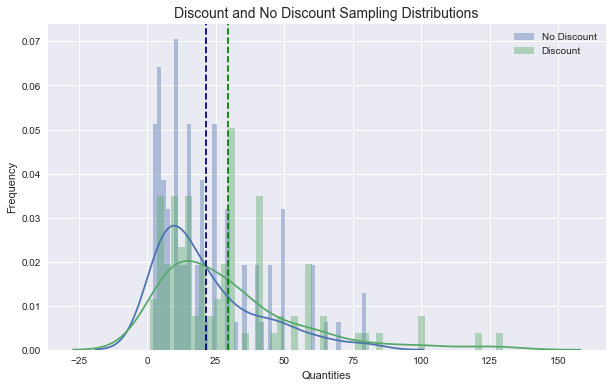

In [491]:
plt.figure(figsize=(10, 6))
plt.grid(True)
sns.distplot(sample_no_discount, bins=50, label = 'No Discount')
sns.distplot(sample_discount, bins=50, label = 'Discount')

plt.axvline(x=sample_no_discount.mean(), color='navy', linestyle = '--')
plt.axvline(x=sample_discount.mean(), color='g', linestyle = '--')

plt.title('Discount and No Discount Sampling Distributions', fontsize = 14)
plt.xlabel('Quantities')
plt.ylabel('Frequency')

plt.legend()
plt.show();

### Welch's T-test - unequal variances, two-sample test, test hypothesis when population has equal means. Discount vs. Non-discouted order quantities - FIX THIS

In [492]:
p = stats.ttest_ind(no_discount.Quantity, discount.Quantity)[1]
print("p-value: ", p)
print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')

p-value:  1.1440924523215966e-10
Reject Null Hypothesis


Effect Size:

In [493]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [494]:
d = Cohen_d(no_discount.Quantity, discount.Quantity)
print("Cohen's d: ", d)

Cohen's d:  0.2862724481729283


The p-value is extremely small, so we reject the null hypothesis that there is no difference between the quantity of orders without a discount vs the quantity of orders with a discount. We can conclude from this result, that discount does in fact have an effect on the quantity of product ordered.

Now, we will approach the second half of the question - At what discount level is the effect on quantity significant? For this, we must look at the various discount amounts and determine at what amounts of discount affect quantity ordered the most.

In [495]:
data1_pt2 = data1[data1['Discount'] != 0]
print(data1_pt2['Discount'].value_counts())

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64


Since the following discount levels (0.01, 0.02, 0.03, 0.04, 0.06) are so small compared to the other discount levels, let's bin them into 0.05 so we have 5 bins with similar counts. 

In [497]:
data1_pt2['Discount'] = data1['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
data1_pt2['Discount'].value_counts()

0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

For the second part of this question, we will form another null and alternative hypothesis!
 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no difference in the quantity of product for each discount level.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub>There is a difference in the quantity of product ordered at different discount levels.

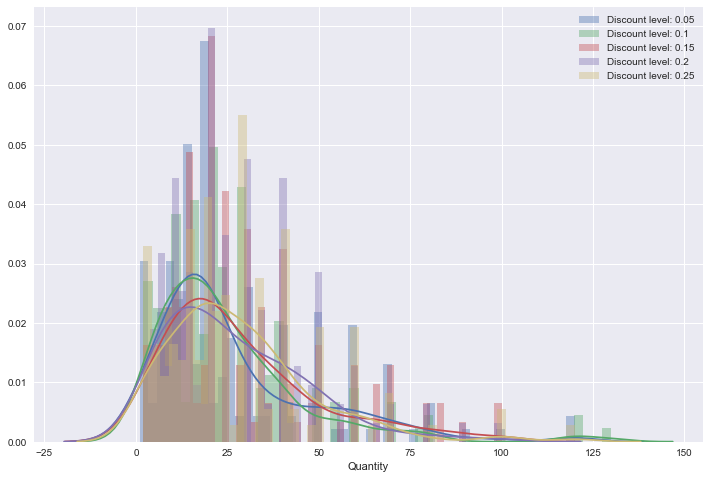

In [502]:
plt.figure(figsize=(12, 8))
for i in sorted(data1_pt2.Discount.unique()):
    sns.distplot(data1_pt2.loc[data1_pt2.Discount==i]['Quantity'], label = 'Discount level: '+str(i), bins=50)
plt.legend()
plt.show()

We will use a one-way analysis of variance or ANOVA since we are considering only one independent variable, which is discount level. 

In [507]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, data1_pt2).fit()
table = sm.stats.anova_lm(lm, typ=1) # for one way analysis
print(table)
lm.summary()

                df         sum_sq     mean_sq         F    PR(>F)
C(Discount)    4.0    1065.701253  266.425313  0.616376  0.650947
Residual     833.0  360060.198508  432.245136       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6164
Date:                Tue, 08 Oct 2019   Prob (F-statistic):              0.651
Time:                        17:29:07   Log-Likelihood:                -3729.5
No. Observations:                 838   AIC:                             7469.
Df Residuals:                     833   BIC:                             7493.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              26.9223      1.497     17.990      0.000      23.985      29.860
C(Discount)[T.0.1]     -1.6853      2.177     -0.774      0.439      -5.958       2.587
C(Discount)[T.0.15]     1.4599      2.234      0.653      0.514      -2.926       5.846
C(Discount)[T.0.2]      0.1026      2.219      0.046      0.963      -4.253       4.458
C(Discount)[T.0.25]     1.3180      2.246      0.587      0.558      -3.091       5.727
==============================================================================
Omnibus:                      265.156   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              753.997
Skew:                           1.593   Prob(JB):                    1.87e-164
Kurtosis:                       6.383   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Question 2 
## *Which Employees bring in more revenue? USA or UK?*

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no difference in the revenue US employees bring in compared to UK employees.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub> There is a statistically significant difference in the revenue from US employees and UK employees

In [170]:
Employee_df['Region'].unique()
# we can see that there employees are either from North America or the British Isles

array(['North America', 'British Isles'], dtype=object)

In [171]:
# We need the sum of the orders (in $) as well as the employee ID and the region of that employee. 
# We will make two dataframes, one for US and one for UK
US_employee_df = pd.read_sql_query('''SELECT EmployeeID , Region, 
                             SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                             FROM [Order] 
                             INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                             INNER JOIN Employee ON Employee.Id = [Order].EmployeeId
                             WHERE Region = 'North America'
                             GROUP BY EmployeeID ORDER BY Revenue DESC
                             ;''', conn)
US_employee_df.head()

,EmployeeId,Region,Revenue
0,4,North America,249536.3550
1,3,North America,212652.6125
2,1,North America,201763.0405
3,2,North America,177431.4755
4,8,North America,132962.2245


In [172]:
UK_employee_df = pd.read_sql_query('''SELECT EmployeeID , Region, 
                             SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                             FROM [Order] 
                             INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                             INNER JOIN Employee ON Employee.Id = [Order].EmployeeId
                             WHERE Region = 'British Isles'
                             GROUP BY EmployeeID ORDER BY Revenue DESC
                             ;''', conn)
UK_employee_df.head()

,EmployeeId,Region,Revenue
0,7,British Isles,140868.0110
1,9,British Isles,82771.5430
2,6,British Isles,78006.7955
3,5,British Isles,75352.9100


In [173]:
rev_by_emp = pd.read_sql_query('''SELECT EmployeeID , Region, 
                             SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                             FROM [Order] 
                             INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                             INNER JOIN Employee ON Employee.Id = [Order].EmployeeId
                             GROUP BY EmployeeID ORDER BY Revenue DESC
                             ;''', conn)
rev_by_emp

,EmployeeId,Region,Revenue
0,4,North America,249536.3550
1,3,North America,212652.6125
2,1,North America,201763.0405
3,2,North America,177431.4755
4,7,British Isles,140868.0110
5,8,North America,132962.2245
6,9,British Isles,82771.5430
7,6,British Isles,78006.7955
8,5,British Isles,75352.9100


In [ ]:
# Get the median of Revenue to create the samples
rev_med = 

# Question 3 
## *Do people who order more frequently than average also generate more sales?*

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> Customers who place orders more frequently spend the same amount as customers who order less frequently.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub> Customers who place more orders spend more money than customers who place less orders. 
<br/>
<br/>
To answer this question, we need the total sales amount per customerID and the count of orders placed by each customerID.

In [47]:
data3 = pd.read_sql_query('''SELECT o.CustomerID,
                             SUM((od.UnitPrice*od.Quantity) - 
                             (od.UnitPrice*od.Quantity*od.Discount)) as 'TotalAmount',
                             COUNT(o.Id) as 'CountOrders'
                             FROM 'Order' o 
                             JOIN 'OrderDetail' od ON o.ID = od.OrderId
                             GROUP BY o.CustomerId
                             ;''', conn)

In [48]:
data3.head() 

,CustomerId,TotalAmount,CountOrders
0,ALFKI,4273.0000,12
1,ANATR,1402.9500,10
2,ANTO,7023.9775,17
3,AROUT,13390.6500,30
4,BERGS,24927.5775,52


In [49]:
data3.info() # brief overview - no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
CustomerId     89 non-null object
TotalAmount    89 non-null float64
CountOrders    89 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [52]:
# Get the median of the order frequency to create the samples
med_CO = data3['CountOrders'].median()
med_CO

20.0

In [72]:
# Create 2 sample groups, high frequency and low frequency
high_freq = data3.loc[data3['CountOrders'] > med_CO]
low_freq = data3.loc[data3['CountOrders']<= med_CO]

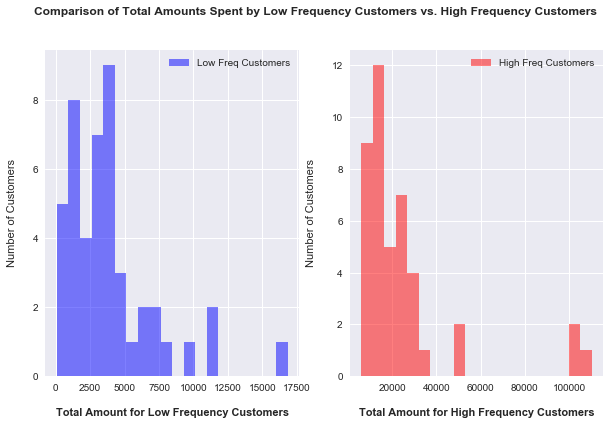

In [93]:
# Check normality 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

ax1.hist(low_freq['TotalAmount'], bins = 20, color = 'b', alpha= 0.5, label = 'Low Freq Customers') 
ax1.set_xlabel('\nTotal Amount for Low Frequency Customers', fontweight='bold')
ax1.set_ylabel('Number of Customers\n')
ax1.legend()

ax2.hist(high_freq['TotalAmount'], bins = 20, color = 'r', alpha= 0.5, label = 'High Freq Customers') 
ax2.set_xlabel('\nTotal Amount for High Frequency Customers', fontweight='bold')
ax2.set_ylabel('Number of Customers\n')
ax2.legend()

fig.suptitle('Comparison of Total Amounts Spent by Low Frequency Customers vs. High Frequency Customers', fontweight='bold')
plt.show()

Both distributions look skewed to the left, therefore not normally distributed. Just for sanity sake, we'll double check using the Shapiro-Wilk test for normality.

In [96]:
print(scs.shapiro(high_freq['TotalAmount']))
print(scs.shapiro(low_freq['TotalAmount']))

(0.6320275068283081, 3.807205661843227e-09)
(0.8364682793617249, 1.392168542224681e-05)


Both p-values are extremely small, which confirms that the distributions are not normal. Now we will perform the Levene test to check the homogeneity of variances.

In [97]:
print(scs.levene(high_freq['TotalAmount'], low_freq['TotalAmount']))

LeveneResult(statistic=11.818379956321802, pvalue=0.0009019045930232378)


The low p-value indicates that the variances between the two samples are unequal. Since the distribution is not normal and the variances are different, we should not use a t-test. 
<br/>
<br/>
Instead, we will use a non-parametric method: the Monte Carlo simulation.

In [109]:
len(high_freq), len(low_freq)

(43, 46)

In [405]:
mean_diff = np.mean(high_freq['TotalAmount']) - np.mean(low_freq['TotalAmount'])
mean_diff

21086.921466632968

In [ ]:
#### below is if we were to take random sampling of data

In [400]:
sample_high_freq = high_freq.sample(n=30)

In [401]:
sample_high_freq.shape

(30, 3)

In [402]:
sample_low_freq = low_freq.sample(n=30)

In [403]:
sample_low_freq.shape

(30, 3)

In [404]:
sample_mean_diff = sample_high_freq['TotalAmount'].mean() - sample_low_freq['TotalAmount'].mean()
sample_mean_diff

19368.913083333337

In [ ]:
import time

Starting 10 samples


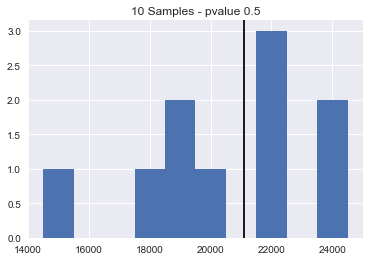

Took 0.12
Starting 100 samples


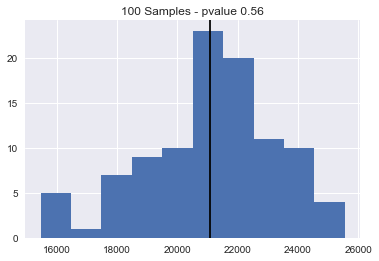

Took 0.2
Starting 500 samples


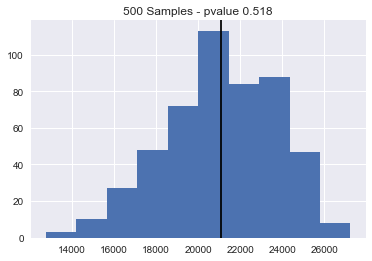

Took 0.78
Starting 1000 samples


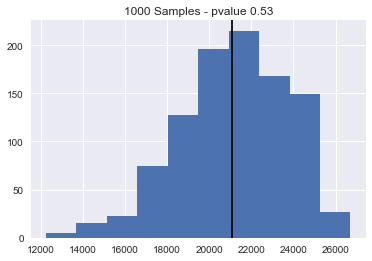

Took 0.97
Starting 10000 samples


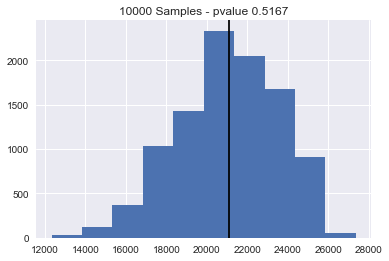

Took 8.28
Starting 100000 samples


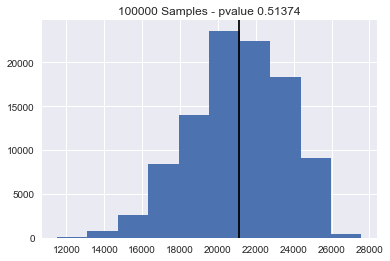

Took 85.66


In [423]:
for x in [10, 100, 500, 1000, 10000, 100000]:
    t0 = time.time()
    print(f'Starting {x} samples')
    mean_diff = np.mean(high_freq['TotalAmount'])-np.mean(low_freq['TotalAmount'])

    sample_diffs = []

    counter = 0

    for i in range(x):
        sample_high_freq = data3.sample(n=30)
        sample_low_freq = data3.sample(n=30)
        sample_mean_diff = sample_high_freq['TotalAmount'].mean() - sample_low_freq['TotalAmount'].mean()
        sample_diffs.append(sample_mean_diff)
        if sample_mean_diff > mean_diff:
            counter+= 1
            
    plt.hist(sample_diffs)
    plt.axvline(mean_diff, color = 'k')
    plt.title(f'{x} Samples - pvalue {counter/x}');
    plt.show()
    t1 = time.time()
    print(f'Took {np.round(t1-t0, 2)}')

In [416]:
counter/10000

0.5167

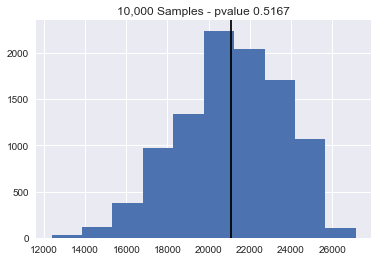

In [422]:
plt.hist(sample_diffs);
plt.axvline(mean_diff, color = 'k')
plt.title(f'10,000 Samples - pvalue {counter/10000}');
plt.show()

# Question 4 
## *Is there a significant difference in the freight costs per region?*

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no significant difference in the freight costs per region.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub> There are significant differences in the freight costs per region.
<br/>
<br/>
To answer this question, we need the sum of the freight costs by region

In [126]:
Order_df['ShipRegion'].unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [135]:
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


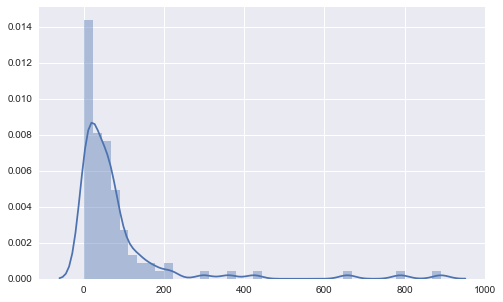

In [303]:
sns_histogram(np.random.choice(df.Freight, size=100), bins=40)

In [304]:
sample_means = []

for i in range(50):
    samp = np.random.choice(df.Freight, size=50).mean()
    sample_means.append(samp)

In [305]:
sd = np.std(sample_means, ddof=1)

In [306]:
sd, np.std(sample_means)

(17.930471309524965, 17.75026099397031)

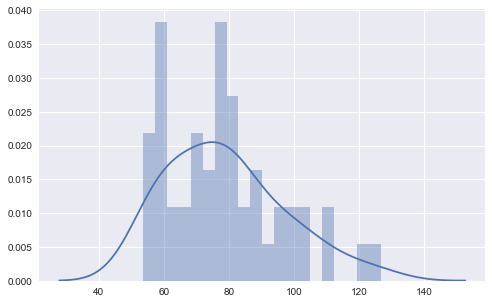

In [307]:
sns_histogram(sample_means)

In [308]:
scs.shapiro(sample_means)
# p-value is 0.03, we reject the null hypothesis that the distribution is normal

(0.9493070244789124, 0.03195267543196678)

In [309]:
samp1 = np.random.choice(df.Freight, size=100)
samp2 = np.random.choice(df.Freight, size=100)
scs.levene(samp1, samp2) 
# High p-value, fail to reject the null hypothesis that there is no difference 
# in the variance between the two samples

LeveneResult(statistic=0.23492055527510156, pvalue=0.6284348265815443)

In [157]:
SumFr_ShipReg = pd.read_sql_query('''SELECT SUM(Freight) as 'SumFreight', ShipRegion
                             FROM [Order]
                             GROUP BY ShipRegion
                             ORDER BY Freight DESC
                             ;''', conn)
SumFr_ShipReg

,SumFreight,ShipRegion
0,8213.95,South America
1,15969.38,North America
2,25561.29,Western Europe
3,2369.86,Southern Europe
4,1186.39,Scandinavia
5,5709.51,British Isles
6,175.74,Eastern Europe
7,4633.79,Northern Europe
8,1122.78,Central America


In [301]:
df = pd.read_sql("SELECT * from [order]", conn)
df.head()
df1 = pd.read_sql("SELECT Freight, ShipRegion from [order]", conn)

In [236]:
sa = df.Freight[df.ShipRegion=='South America']
na = df.Freight[df.ShipRegion=='North America']
we = df.Freight[df.ShipRegion=='Western Europe']
se = df.Freight[df.ShipRegion=='Southern Europe']
sca = df.Freight[df.ShipRegion=='Scandanavia']
uk = df.Freight[df.ShipRegion=='British Isles']
ee = df.Freight[df.ShipRegion=='Eastern Europe']
ne = df.Freight[df.ShipRegion=='Northern Europe']
ca = df.Freight[df.ShipRegion=='Central America']

In [237]:
scs.f_oneway(na, we, uk)

F_onewayResult(statistic=1.1809900110290237, pvalue=0.30782947863461485)

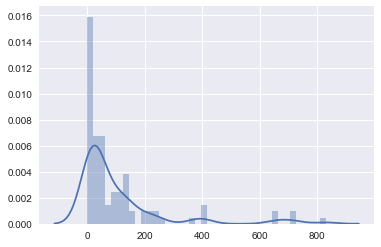

In [238]:
sns.distplot(np.random.choice(na, size=100), bins=40);

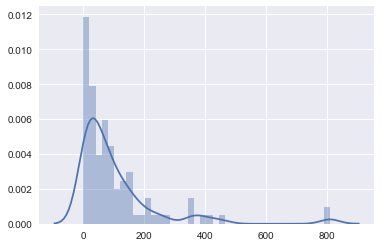

In [239]:
sns.distplot(np.random.choice(we, size=100), bins=40);

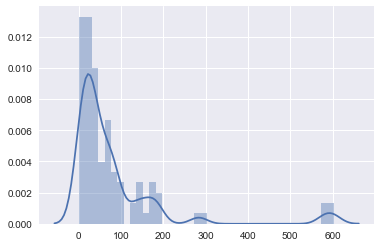

In [240]:
sns.distplot(np.random.choice(uk, size=100), bins=40);

In [241]:
mod = MultiComparison(df.Freight, df.ShipRegion)

In [242]:
print(mod.tukeyhsd())

        Multiple Comparison of Means - Tukey HSD,FWER=0.05        
     group1          group2     meandiff   lower    upper   reject
------------------------------------------------------------------
 British Isles  Central America -36.0275 -115.2593 43.2043  False 
 British Isles   Eastern Europe -51.0211 -192.4108 90.3686  False 
 British Isles   North America  28.9349   -21.5488 79.4186  False 
 British Isles  Northern Europe  8.1239   -55.3872 71.6351  False 
 British Isles    Scandinavia   -33.7557 -112.9875 45.4761  False 
 British Isles   South America  -19.4789  -70.3636 31.4058  False 
 British Isles  Southern Europe -39.0977  -99.9781 21.7826  False 
 British Isles   Western Europe 16.4866   -30.0998 63.0729  False 
Central America  Eastern Europe -14.9936 -166.1743 136.1872 False 
Central America  North America  64.9624   -8.6118  138.5367 False 
Central America Northern Europe 44.1514   -38.9042 127.2071 False 
Central America   Scandinavia    2.2718   -93.3433 97.8869  Fa

From the Tukey multi comparison test, we can see that there is a significant difference between the means of the following:
 - North America vs. South America
 - North America vs. Southern Europe
 - Southern Europe vs. Western Europe

In [513]:
d_na_sa = Cohen_d(na, sa)
print("Cohen's d for North America and South America is: {}".format(d_na_sa))

Cohen's d of North America and South America is: 0.3889410582308617


In [ ]:
#diverging bar graph
df = pd.read_csv("https://github.com/selva86/datasets/raw/master/mtcars.csv")
x = df.loc[:, ['mpg']]
df['mpg_z'] = (x - x.mean())/x.std()
df['colors'] = ['red' if x < 0 else 'green' for x in df['mpg_z']]
df.sort_values('mpg_z', inplace=True)
df.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=df.index, xmin=0, xmax=df.mpg_z, color=df.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='$Model$', xlabel='$Mileage$')
plt.yticks(df.index, df.cars, fontsize=12)
plt.title('Diverging Bars of Car Mileage', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

Now that we know which groups are significantly different, let's see how different using Cohen's D to determine effect size.

# Business Recommendations: